# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch. 
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [1]:
!pip install transformers

     |████████████████████████████████| 2.1MB 17.4MB/s 
     |████████████████████████████████| 3.3MB 54.6MB/s 
     |████████████████████████████████| 901kB 49.7MB/s 


In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!nvidia-smi

Wed Apr 21 00:23:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [96]:
# load into a data frame
df = pd.read_csv ('/content/Taunts .csv')  
print(df)
# df_zeroTaunts = df.loc[df["Score_Diff"] == 0]
df_aheadTaunts = df.loc[df["Score_Diff"] == 1]
df_behindTaunts = df.loc[df["Score_Diff"] != 1]

     Score_Diff      Key                            Taunt_str
0            -1  hMmGfAV                          You're good
1            -1  xhUUnAk                                  Oof
2            -1  QOuWOFc    I can't believe you've done this!
3            -1  YcGdCNF               You shall rue the day!
4            -1  PEfjsbS              I will have my revenge!
..          ...      ...                                  ...
100           1  IcxPiyt                      You're dogwater
101           1  wgkJDow              Are you trying to lose?
102           1  dnZefxT                         You're trash
103           1  wMcydNl  My grandma can play better than you
104           1  sidjKNo              Who's the real bot here

[105 rows x 3 columns]


In [97]:
#df =  df_zeroTaunts
#df =  df_aheadTaunts
df =  df_behindTaunts
df = df.append(df_behindTaunts)

In [98]:
df

,Score_Diff,Key,Taunt_str
0,-1,hMmGfAV,You're good
1,-1,xhUUnAk,Oof
2,-1,QOuWOFc,I can't believe you've done this!
3,-1,YcGdCNF,You shall rue the day!
4,-1,PEfjsbS,I will have my revenge!
...,...,...,...
44,0,FMdSLZA,"Goodness, What a show!"
45,0,uXiaHac,You understimate my power!
46,0,PjVfoUQ,I'm just biding my time
47,0,YsCvSBC,You are a fighter


In [99]:
df.dropna(inplace=True) #remove NA values
bios = df.Taunt_str.copy() #just use the main bio text in this example
bios

0                           You're good
1                                   Oof
2     I can't believe you've done this!
3                You shall rue the day!
4               I will have my revenge!
                    ...                
44               Goodness, What a show!
45           You understimate my power!
46              I'm just biding my time
47                    You are a fighter
48       You haven't seen me at my peak
Name: Taunt_str, Length: 98, dtype: object

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


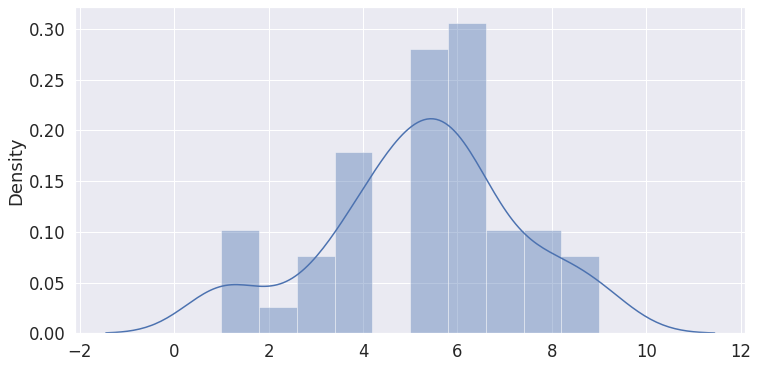

In [100]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [101]:
# the max token length   
len(doc_lengths[doc_lengths > 0])/len(doc_lengths)

1.0

In [102]:
np.average(doc_lengths)

5.244897959183674

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [103]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [104]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [105]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [106]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=1024):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [107]:
dataset = GPT2Dataset(bios, tokenizer, max_length=1024)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

   88 training samples
   10 validation samples


In [108]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [109]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [110]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [111]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [112]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [113]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [114]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...

  Average training loss: 0.54
  Training epoch took: 0:00:31

Running Validation...
  Validation Loss: 0.19
  Validation took: 0:00:01

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.08
  Training epoch took: 0:00:32

Running Validation...
  Validation Loss: 0.02
  Validation took: 0:00:01

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.02
  Training epoch took: 0:00:32

Running Validation...
  Validation Loss: 0.02
  Validation took: 0:00:01

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.02
  Training epoch took: 0:00:33

Running Validation...
  Validation Loss: 0.01
  Validation took: 0:00:01

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.01
  Training epoch took: 0:00:33

Running Validation...
  Validation Loss: 0.01
  Validation took: 0:00:01

Training complete!
Total training took 0:02:46 (h:mm:ss)


Let's view the summary of the training process.

In [115]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.54,0.19,0:00:31,0:00:01
2,0.08,0.02,0:00:32,0:00:01
3,0.02,0.02,0:00:32,0:00:01
4,0.02,0.01,0:00:33,0:00:01
5,0.01,0.01,0:00:33,0:00:01


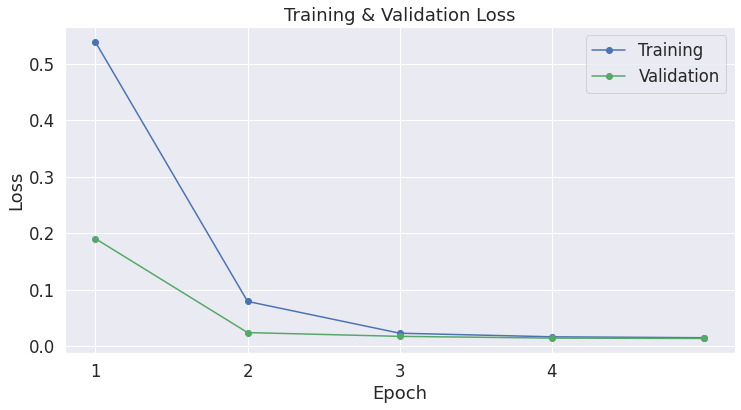

In [116]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [117]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [118]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [119]:
!ls -l --block-size=K ./model_save/

total 499796K
-rw-r--r-- 1 root root      1K Apr 21 01:24 added_tokens.json
-rw-r--r-- 1 root root      1K Apr 21 01:24 config.json
-rw-r--r-- 1 root root    446K Apr 21 01:24 merges.txt
-rw-r--r-- 1 root root 498452K Apr 21 01:24 pytorch_model.bin
-rw-r--r-- 1 root root      1K Apr 21 01:24 special_tokens_map.json
-rw-r--r-- 1 root root      1K Apr 21 01:24 tokenizer_config.json
-rw-r--r-- 1 root root    878K Apr 21 01:24 vocab.json


In [120]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Apr 21 01:24 ./model_save/pytorch_model.bin


In [121]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

cp: missing destination file operand after './model_save/'
Try 'cp --help' for more information.


# Generate Text

In [123]:
model.eval()
prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 500,
                                top_p=0.95, 
                                num_return_sequences=20
                                )
taunts = []
for i, sample_output in enumerate(sample_outputs):
  taunts.append(tokenizer.decode(sample_output, skip_special_tokens=True))
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
with open("/content/addBad.txt",'w+') as inf:
    for n in taunts:
        inf.write(n + '\n')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: Hikes, my...


1: The only one that stands!


2: Wow!


3: I have the power


4: You haven't seen my!


5: I can't try that next one, what's your next?


6: You're not that serious?


7: I will see you!


8: Time to win my revenge after the break!


9: You're not good


10: You're not finished yet


11: Foolish, won't believe me!


12: I'm just a friend!


13: I can't win!


14: I think we can do better


15: Hof


16: Theness's proud


17: I am not your friend


18: Hp at what my next moves


19: 




These aren't bad at all!
